#### Libraries

In [59]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sqlite3
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import os
from dotenv import load_dotenv


#### Connector to Snowflake

In [61]:
load_dotenv("snowflake.env")

conn = snowflake.connector.connect(
user=os.getenv("SNOWFLAKE_USER"),
password=os.getenv("SNOWFLAKE_PASSWORD"),
account=os.getenv("SNOWFLAKE_ACCOUNT"),
database=os.getenv("SNOWFLAKE_DaTABASE"),
schema=os.getenv("SNOWFLAKE_SCHEMA")
)

cur = conn.cursor()


##### Hourly DataFrame

In [62]:
cur.execute('select * from "hourly_data"')
df = cur.fetch_pandas_all()

df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['date'])

df.head()


,time,temperature,rain,snowfall,wind_speed,year,month,day,date
0,2010-01-01 00:00:00,-6.6,0.0,0.0,9.7,2010,1,1,2010-01-01
1,2010-01-01 01:00:00,-6.7,0.0,0.0,10.1,2010,1,1,2010-01-01
2,2010-01-01 02:00:00,-6.7,0.0,0.0,10.1,2010,1,1,2010-01-01
3,2010-01-01 03:00:00,-6.6,0.0,0.0,11.2,2010,1,1,2010-01-01
4,2010-01-01 04:00:00,-6.7,0.0,0.0,12.2,2010,1,1,2010-01-01


##### Daily DataFrame

In [63]:
cur.execute('select * from "daily_data"')
df_daily = cur.fetch_pandas_all()
df_daily['date']=pd.to_datetime(df_daily['date'])
df_daily.head()

,date,temperature,rain,snowfall,wind_speed,year,month,day
0,2010-01-01,-6.412500,0.0,0.56,14.462500,2010,1,1
1,2010-01-02,-8.400000,0.0,0.00,13.045833,2010,1,2
2,2010-01-03,-10.791667,0.0,0.00,15.058333,2010,1,3
3,2010-01-04,-8.904167,0.0,0.00,15.037500,2010,1,4
4,2010-01-05,-15.579167,0.0,0.00,12.479167,2010,1,5


##### Monthly DataFrame

In [64]:
cur.execute('select * from "monthly_data"')
df_monthly = cur.fetch_pandas_all()

df_monthly.head()

,temperature,rain,snowfall,wind_speed,year,month
0,-6.977151,0.0,16.24,11.461022,2010,1
1,-5.444643,0.8,27.23,11.290774,2010,2
2,-1.437634,8.0,14.00,12.629032,2010,3
3,4.645417,21.5,5.81,11.045278,2010,4
4,10.004032,45.3,0.00,10.530914,2010,5


In [42]:
cur.execute('select * from "yearly_data"')
df_yearly = cur.fetch_pandas_all()

df_yearly.head()

,temperature,rain,snowfall,wind_speed,year
0,5.343413,390.1,143.57,12.258973,2010
1,7.724589,433.1,77.56,13.740662,2011
2,6.694262,694.1,114.94,13.484381,2012
3,7.031473,435.4,49.63,13.119132,2013
4,8.169726,481.0,57.26,13.309018,2014


### Trend of Temperature , Rain , Snow

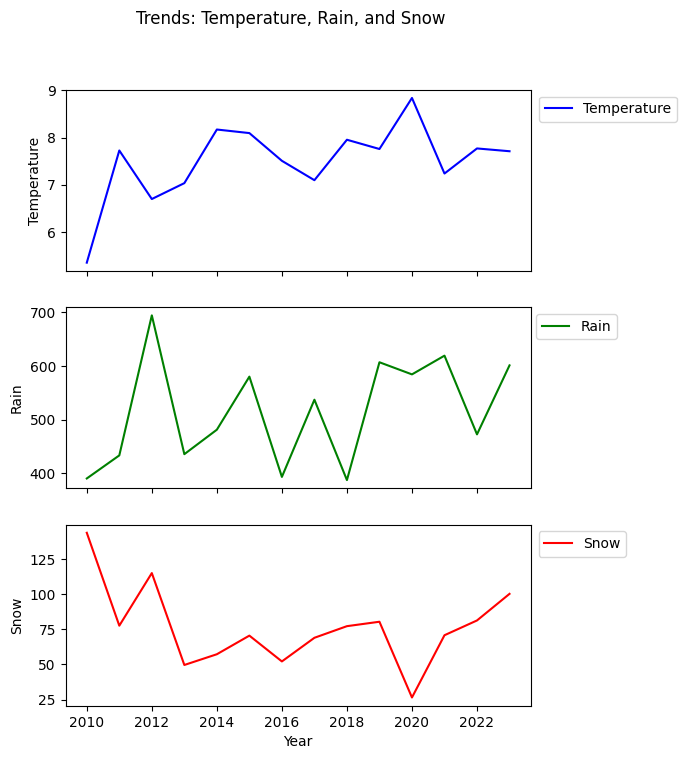

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# temperature trend
sns.lineplot(x='year', y='temperature', data=df_yearly, ax=ax1, label='Temperature', color='blue')
ax1.set_ylabel('Temperature')
ax1.legend(loc='upper right', bbox_to_anchor=(1.33, 1))

# rain trend
sns.lineplot(x='year', y='rain', data=df_yearly, ax=ax2, label='Rain', color='green')
ax2.set_ylabel('Rain')
ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# snow trend
sns.lineplot(x='year', y='snowfall', data=df_yearly, ax=ax3, label='Snow', color='red')
ax3.set_xlabel('Year')
ax3.set_ylabel('Snow')
ax3.legend(loc='upper right', bbox_to_anchor=(1.22, 1))

plt.suptitle('Trends: Temperature, Rain, and Snow')
plt.show()


### Correlation between temperature, rain, and snow?

In [65]:
correlation_matrix = df_yearly[['temperature', 'snowfall', 'rain']].corr()
correlation_matrix

,temperature,snowfall,rain
temperature,1.000000,-0.757392,0.174606
snowfall,-0.757392,1.000000,0.044305
rain,0.174606,0.044305,1.000000


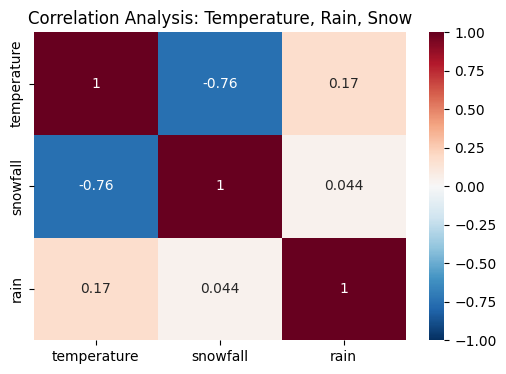

In [66]:
fig = plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Correlation Analysis: Temperature, Rain, Snow')

plt.show()


### Identify years with extreme weather events

In [67]:
# top 5% of temperature / snowfall / rainfall
extreme_rainfall_year = df_yearly[df_yearly['rain'] > df_yearly['rain'].quantile(0.95)].reset_index(drop=True)
extreme_snowfall_year = df_yearly[df_yearly['snowfall'] > df_yearly['snowfall'].quantile(0.95)].reset_index(drop=True)
extreme_temperature_year = df_yearly[df_yearly['temperature'] > df_yearly['temperature'].quantile(0.95)].reset_index(drop=True)

print(f"Top 5% of extreme year in terms of temperatue = {extreme_temperature_year.loc[0,'year']}  ") 
print(f"Top 5% of extreme year in terms of rainfall = {extreme_rainfall_year.loc[0,'year']} ") 
print(f"Top 5% of extreme year in terms of snowfall = {extreme_snowfall_year.loc[0,'year']} ") 


Top 5% of extreme year in terms of temperatue = 2020  
Top 5% of extreme year in terms of rainfall = 2012 
Top 5% of extreme year in terms of snowfall = 2010 


### How is the distribution of temperatures within each year?

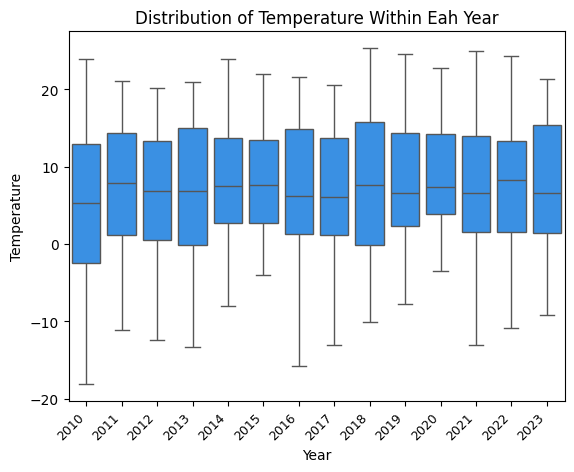

In [68]:
sns.boxplot(x='year', y='temperature', data=df_daily , color='dodgerblue')
plt.xticks(rotation=45, ha='right', size=9)
plt.title('Distribution of Temperature Within Eah Year')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

### How does the intensity of rainfall vary over the years?
#### Identify Years with Consistently High or Low Rainfall

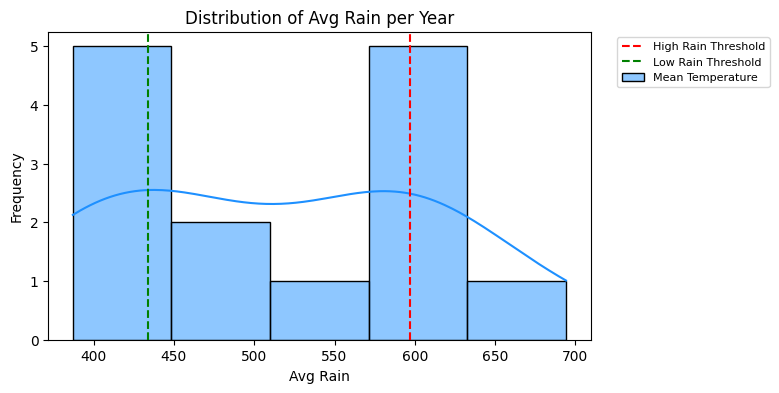

In [69]:
#identify high and low threshold
high_rain_threshold = df_yearly['rain'].quantile(0.75)
low_rain_threshold = df_yearly['rain'].quantile(0.25)

consistently_high_rain_years = df_yearly[df_yearly['rain'] > high_rain_threshold]
consistently_low_rain_years = df_yearly[df_yearly['rain'] < low_rain_threshold]

plt.figure(figsize=(7, 4))
sns.histplot(df_yearly['rain'], kde=True, label='Mean Temperature', color='dodgerblue')
plt.axvline(high_rain_threshold, color='red', linestyle='--', label='High Rain Threshold')
plt.axvline(low_rain_threshold, color='green', linestyle='--', label='Low Rain Threshold')
plt.title('Distribution of Avg Rain per Year')
plt.xlabel('Avg Rain')
plt.ylabel('Frequency')
plt.legend(loc='upper right', bbox_to_anchor=(1.34, 1), prop={'size': 8})
plt.show()


##### Years with Consistently High Rain

In [70]:
consistently_high_rain_years[['year','rain']].sort_values(by='rain', ascending=False).reset_index(drop=True)

,year,rain
0,2012,694.1
1,2021,619.0
2,2019,606.7
3,2023,600.9


##### Years with Consistently Low Rain

In [71]:
consistently_low_rain_years[['year','rain']].sort_values(by='rain', ascending=True).reset_index(drop=True)

,year,rain
0,2018,387.1
1,2010,390.1
2,2016,393.0
3,2011,433.1


### Identify the hottest Month of Each Year

In [72]:
hottest_months=df_monthly.loc[df_monthly.groupby('year')['temperature'].idxmax()]
#another way 
#hottest_months = df_sorted.groupby('year').head(1).sort_values('year')

hottest_months[['year', 'month', 'temperature']]

,year,month,temperature
6,2010,7,20.172715
15,2011,7,18.526613
24,2012,7,16.996237
30,2013,7,17.558871
75,2014,7,19.497177
78,2015,8,17.440457
85,2016,7,18.148656
90,2017,7,16.280108
97,2018,7,21.093011
101,2019,6,17.432778


##### Display the Hottest Month of Each Year


C:\Users\Saba\AppData\Local\Temp\ipykernel_4336\3398238782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['y-m'] = result['year'].astype(str) + '-' + result['month'].astype(str)


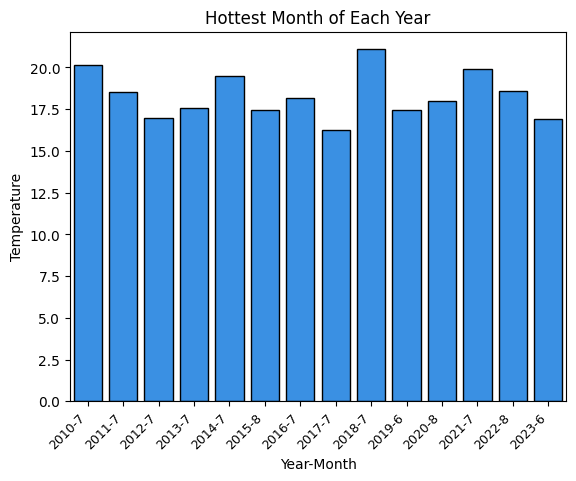

In [73]:
result= hottest_months[['year', 'month', 'temperature']]
result['y-m'] = result['year'].astype(str) + '-' + result['month'].astype(str)

sns.barplot(x='y-m', y='temperature', data=result, color='dodgerblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', size=9)
plt.ylabel('Temperature')
plt.xlabel('Year-Month')
plt.title('Hottest Month of Each Year')
plt.show()

### Find Outlier(Anomaly) Temperature in Winter

In [74]:
winter_month=[ 12 , 1 , 2 ]
df_daily_winter=df_daily[df_daily['month'].isin(winter_month)]

In [75]:
seventy_fifth=df_daily_winter['temperature'].quantile(0.75)
twenty_fifth=df_daily_winter['temperature'].quantile(0.25)
iqr=seventy_fifth-twenty_fifth

upper=seventy_fifth+(1.5*iqr)
lower=twenty_fifth-(1.5*iqr)

print(f"Dates with temperatue above {upper:.2f} and less than {lower: .2f}")

df_daily_winter[(df_daily_winter['temperature']<lower) | (df_daily_winter['temperature']>upper)][['date' , 'temperature']]\
.style.background_gradient()

Dates with temperatue above 10.18 and less than -11.59


,date,temperature
4,2010-01-05 00:00:00,-15.579167
5,2010-01-06 00:00:00,-13.800000
8,2010-01-09 00:00:00,-12.433333
33,2010-02-22 00:00:00,-15.912500
60,2010-01-26 00:00:00,-12.345833
62,2010-01-30 00:00:00,-11.775000
72,2010-02-21 00:00:00,-12.775000
308,2010-12-01 00:00:00,-14.729167
354,2010-12-22 00:00:00,-18.133333
482,2010-12-21 00:00:00,-12.350000


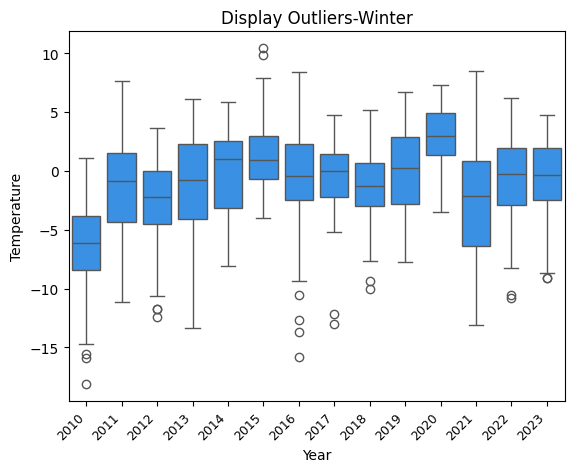

In [76]:
# Ploting outliers

sns.boxplot(x='year', y='temperature', data=df_daily_winter , color='dodgerblue')
plt.title('Display Outliers-Winter')
plt.xticks(rotation=45, ha='right', size=9)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

### Find Outlier(Anomaly) of Temperature in Summer

In [77]:
summer_month=[6,7,8 ]
df_summer_month=df_daily[df_daily['month'].isin(summer_month)]

seventy_fifth=df_summer_month['temperature'].quantile(0.75)
twenty_fifth=df_summer_month['temperature'].quantile(0.25)
iqr=seventy_fifth-twenty_fifth

upper=seventy_fifth+(1.5*iqr)
lower=twenty_fifth-(1.5*iqr)

print(f"Dates with temperatue above {upper:.2f} and less than {lower: .2f}")

df_summer_month[(df_summer_month['temperature']<lower) | (df_summer_month['temperature']>upper)][['date' , 'temperature']]\
.style.background_gradient()

Dates with temperatue above 23.98 and less than  9.65


,date,temperature
882,2012-06-02 00:00:00,5.275000
883,2012-06-03 00:00:00,8.633333
1031,2012-06-01 00:00:00,6.779167
2706,2017-06-02 00:00:00,9.091667
3118,2018-07-16 00:00:00,24.387500
3119,2018-07-17 00:00:00,24.225000
3120,2018-07-18 00:00:00,24.275000
3128,2018-07-26 00:00:00,25.316667
3129,2018-07-27 00:00:00,24.912500
3134,2018-08-01 00:00:00,24.500000


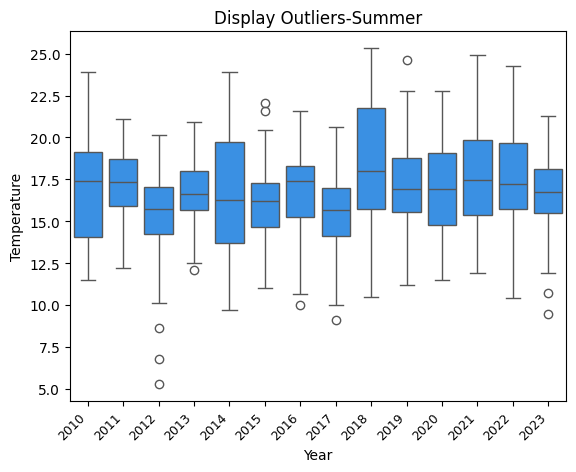

In [57]:
# Ploting outliers

sns.boxplot(x='year', y='temperature', data=df_summer_month , color='dodgerblue')
plt.title('Display Outliers-Summer')
plt.xticks(rotation=45, ha='right', size=9)
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

### Trend of temperature for each season over years

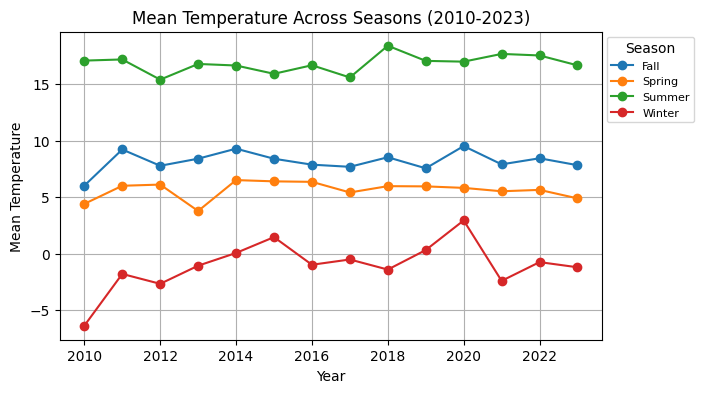

In [82]:
# Identify mapping for season column

season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Fall',
    10: 'Fall',
    11: 'Fall',
    12: 'Winter'
}

df_monthly['season'] = df_monthly['month'].map(season_mapping)
mean_temperature=df_monthly.groupby(['year', 'season'])['temperature'].mean().reset_index()
pivot_table = mean_temperature.pivot(index='year', columns='season', values='temperature')

pivot_table.plot(marker='o', linestyle='-', figsize=(7, 4))
plt.title('Mean Temperature Across Seasons (2010-2023)')
plt.xlabel('Year')
plt.ylabel('Mean Temperature')
plt.legend(title='Season', loc='upper right', bbox_to_anchor=(1.18, 1), prop={'size': 8})
plt.grid(True)
plt.show()